# (3.0) Create AFA dataset by blocking actions 
In this notebook we run the agent on a dataset with missingness and block non-available feature acquisition acitons. We save the created dataset.

Note: AFA agents must be already trained 

In [1]:
%load_ext autoreload
%autoreload 2

## Define paths

Paths for data

In [2]:
from afa.configurations.utils_ts import specify_default_paths_ts
# which dataset to work on 
dataset_name   = "synthetic_1"

# name for of missingness scenario 
miss_scenario  = 'MCAR_1'

# automatically specify some path locations (change paths manually if needed) 
paths = specify_default_paths_ts(dataset_name = dataset_name , miss_scenario = miss_scenario) 

Paths for model

In [3]:
# name for agent (and predictor) 
agent_name            = 'DQN'
predictor_model_name  = 'logistic_regression'

# new (where to save the model) 
agent_dir           = paths['data_dir']  + 'afa_agents' + '/' + agent_name + '/'
predictor_model_dir = paths['data_dir']  + 'predictor_models' + '/' + predictor_model_name + '/'

# how to name the afa_dataset
afa_dataset_name = 'blocking'

## Load dataset with missingness 
At first, we want to load the dataset 

Includes loading: 
- superfeature mapping
- problem
- afa_problem 
- missingness_model

In [4]:
from afa.data_modelling.datasets.data_loader.data_loader_ts import DataLoader_ts

2023-02-27 18:53:30.976922: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-27 18:53:31.104187: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 18:53:31.104208: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-27 18:53:31.810395: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [5]:
data_loader = DataLoader_ts(     data_file                  = paths['data_file'],
                                 temporal_data_file         = paths['temporal_data_file'],
                                 superfeature_mapping_file  = paths['superfeature_mapping_file'],
                                 problem_file               = paths['problem_file'],
                                 afa_problem_files          = paths['afa_problem_files'], 
                                 folds_file                 = paths['folds_file'] )
dataset = data_loader.load() 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 718.38it/s]


In [6]:
# define predictor (has to be pretrained) 
predictor_model_params = {
    'name' : predictor_model_name, 
    'directory': predictor_model_dir,
    'base_model_params' : {   
        'model_type': 'ImputeThenRegress',
        'imputer_params' : {
              'model_type': 'simple_imputer',
              'mode' : 'imputation', 
            },
        'predictor_params' : {
              'model_type': 'ann',
              'mode' : 'classification', 
              'units':              1,
              'layers': 1,
              'learning_rate': 0.01,
              'batch_size' :128,
              'epochs': 100
          }
    }
}

In [7]:
# define agent
agent_model_params =  {                       
                    'num_iterations'              : 100,
                    'initial_collect_steps'       : 50,
                    'collect_steps_per_iteration' : 1, 
                    'replay_buffer_max_length'    : 100000 ,
                    'batch_size'                  : 64,
                    'learning_rate'               : 1e-3,
                    'train_steps_per_iteration'   : 1, 
                    'log_interval'                : 200,
                    'num_eval_episodes'           : 50,
                    'eval_interval'               : 500, 
                    'verbose'                     : False
                      }               

In [8]:
# define afa_agent
afa_agent_params = {
    'name' : agent_name,
    'agent_type' : 'dqn_agent',
    'directory' : agent_dir, 
    'predictor_params' : predictor_model_params, 
    'agent_params' : agent_model_params
}

## Initialize Agent 

In [9]:
from afa.afa_models.afa_agents.utils_ts import define_afa_agent_ts

In [10]:
afa_agent = define_afa_agent_ts(    name             = afa_agent_params['name'],  
                                    agent_type       = afa_agent_params['agent_type'],   
                                    afa_agent_params = afa_agent_params ,
                                    agent_directory  = afa_agent_params['directory'])

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...
Load DQN Agent policy... 


2023-02-27 18:53:37.790654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-27 18:53:37.790833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-27 18:53:37.790916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-27 18:53:37.790980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-27 18:53:37.791045: W tensorf

## Create afa dataset 

In [11]:
from afa.afa_datasets.afa_dataset_ts import AFADataset_ts

In [12]:
afa_results = afa_agent.predict(dataset,  n_samples = 1) 

# create an afa_dataset out of the generated afa_results
afa_dataset = AFADataset_ts(  dataset = dataset, model = afa_agent, results = afa_results) 

1/1 [==============================] - 0s 23ms/step


### Run test for consistency check 

In [22]:
from afa.afa_datasets.testing.test_afa_dataset_ts import test_afa_dataset_ts
test_afa_dataset_ts(afa_dataset)

From AFA dataset: 


TypeError: tuple indices must be integers or slices, not str

In [15]:
# save afa_dataset
afa_dataset.save( directory = agent_dir, afa_dataset_name = afa_dataset_name ) 

## Test loading afa dataset 

In [16]:
from afa.afa_datasets.afa_data_loader.afa_data_loader_ts import AFADataLoader_ts

In [23]:
augmented_data_file = agent_dir + afa_dataset_name + '_' + 'results.hkl'
afa_data_loader = AFADataLoader_ts(                   
                    augmented_data_file = augmented_data_file,
                    dataset  = dataset,
                    model_params = afa_agent_params) 
afa_dataset = afa_data_loader.load() 

Loading already trained weights for SimpleImputer...
Loading already trained weights for ann...
Load DQN Agent policy... 


In [24]:
afa_dataset.results.keys()

dict_keys(['ids', 'target_superR_hat', 'label_pred', 'cost_acq', 'cost_mc', 'cost'])

In [25]:
data = afa_dataset.get_data(fold = None, split = None, n_samples = 1) 
# data = afa_dataset.get_data(fold = 0, split = 'val', n_samples = 1) 

### Write report

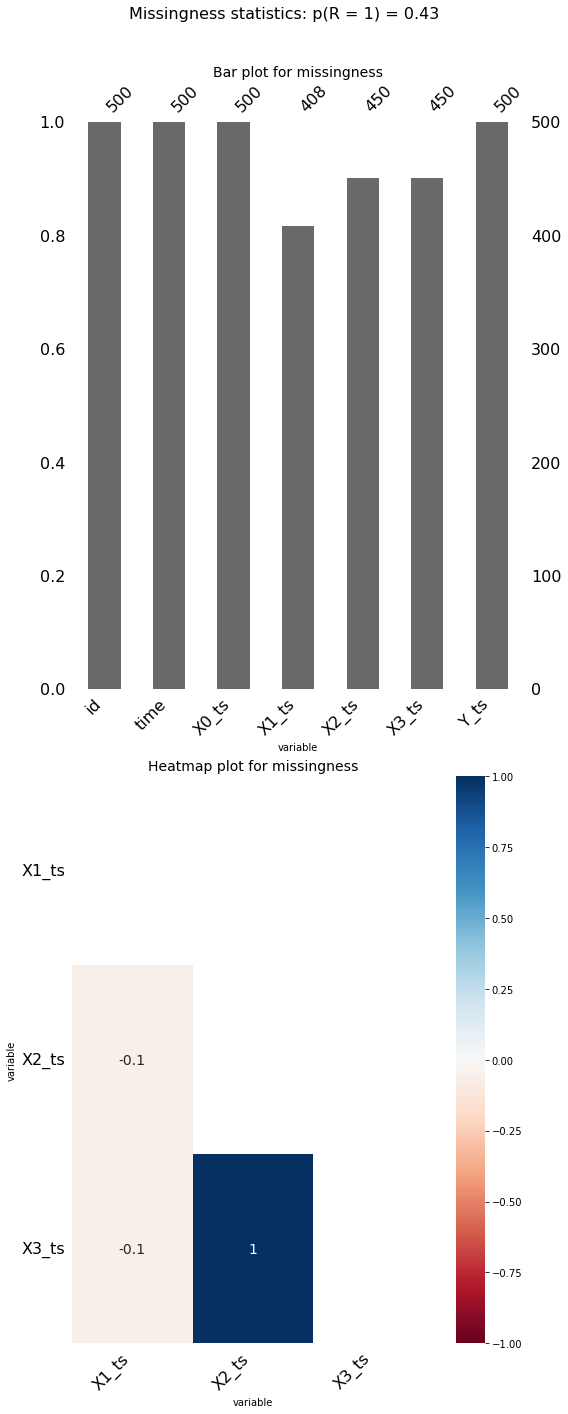

In [26]:
# report 
explanation_file = agent_dir + afa_dataset_name + '_' + 'afa_dataset_report.md'  # +  'reports/' + 'model_report' 
afa_dataset.explain(file= explanation_file, format = 'markdown')